In [1]:
import os
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import time
import base64
import json

In [3]:
url = "https://www.maquillajetrendyshop.com/_v/segment/graphql/v1"

headers = {
    "User-Agent": "Mozilla/5.0",
    "Content-Type": "application/json"
}

In [4]:
def scrape_category(query_path, facet1, facet2, category_name):
    all_products = []
    page = 0
    page_size = 10

    print(f"\nScrapeando categoría: {category_name}")

    while True:
        from_value = page * page_size
        to_value = from_value + page_size - 1

        variables_dict = {
            "hideUnavailableItems": False,
            "skusFilter": "ALL",
            "simulationBehavior": "skip",
            "installmentCriteria": "MAX_WITHOUT_INTEREST",
            "productOriginVtex": False,
            "map": "c,c",
            "query": query_path,
            "orderBy": "OrderByReleaseDateDESC",
            "from": from_value,
            "to": to_value,
            "selectedFacets": [
                {"key": "c", "value": facet1},
                {"key": "c", "value": facet2}
            ],
            "operator": "and",
            "fuzzy": "0",
            "searchState": None,
            "facetsBehavior": "Static",
            "categoryTreeBehavior": "default",
            "withFacets": False
        }

        variables_encoded = base64.b64encode(
            json.dumps(variables_dict).encode()
        ).decode()

        params = {
            "workspace": "master",
            "maxAge": "short",
            "appsEtag": "remove",
            "domain": "store",
            "locale": "es-CO",
            "__bindingId": "762e992d-a355-4c7e-b34c-1657f86d5cca",
            "operationName": "productSearchV3",
            "extensions": json.dumps({
                "persistedQuery": {
                    "version": 1,
                    "sha256Hash": "31d3fa494df1fc41efef6d16dd96a96e6911b8aed7a037868699a1f3f4d365de",
                    "sender": "vtex.store-resources@0.x",
                    "provider": "vtex.search-graphql@0.x"
                },
                "variables": variables_encoded
            })
        }

        response = requests.get(url, headers=headers, params=params)
        data = response.json()

        products = data["data"]["productSearch"]["products"]

        if not products:
            print("Fin de categoría.")
            break

        for p in products:
            try:
                name = p["productName"]
                brand = p.get("brand")
                price = p["items"][0]["sellers"][0]["commertialOffer"]["Price"]
                list_price = p["items"][0]["sellers"][0]["commertialOffer"]["ListPrice"]

                all_products.append({
                    "name": name,
                    "brand": brand,
                    "price": price,
                    "list_price": list_price,
                    "category": category_name
                })
            except:
                continue

        print(f"Página {page+1} procesada")
        page += 1
        time.sleep(1)

    return pd.DataFrame(all_products)

In [5]:
makeup_df = scrape_category(
    "maquillaje/rostro",
    "maquillaje",
    "rostro",
    "Maquillaje Rostro"
)


Scrapeando categoría: Maquillaje Rostro
Página 1 procesada
Página 2 procesada
Página 3 procesada
Página 4 procesada
Página 5 procesada
Página 6 procesada
Página 7 procesada
Fin de categoría.


In [6]:
skincare_df = scrape_category(
    "cuidado-de-la-piel/cuidado-facial",
    "cuidado-de-la-piel",
    "cuidado-facial",
    "Skincare"
)


Scrapeando categoría: Skincare
Página 1 procesada
Página 2 procesada
Fin de categoría.


In [8]:
df_total = pd.concat([makeup_df, skincare_df], ignore_index=True)
df_total

,name,brand,price,list_price,category
0,Kit Piel Mistic Face Ref KMF2247,Trendy,20000,20000,Maquillaje Rostro
1,Kit Mini Favoritos Galaxy 2026 Ref KMF2454,Trendy,130000,130000,Maquillaje Rostro
2,Pin Stitch Guitarra DY2346,Trendy,12000,12000,Maquillaje Rostro
3,Kit Rubor y Gloss Pinky News Ref KPN2248,Trendy,15000,15000,Maquillaje Rostro
4,Corrector Hidrante Rebel Girl Ref CRG1420,Trendy,10000,10000,Maquillaje Rostro
...,...,...,...,...,...
72,Protector Solar Facial 115ML Trendy Skin care ...,Trendy,50000,50000,Skincare
73,Doypack Serum Hidratante Morado Ref DSH1761,Trendy,10000,10000,Skincare
74,Sachet Protector Solar Facial 40ml Ref PSF1213,Trendy,20000,20000,Skincare
75,Colapsible Jabón Détox Pequeño Ref JDP1321,Trendy,12000,12000,Skincare


In [9]:
df_total["discount_%"] = (
    (df_total["list_price"] - df_total["price"])
    / df_total["list_price"]
) * 100

print("\nCantidad de productos por categoría:")
print(df_total["category"].value_counts())

print("\nPrecio promedio por categoría:")
print(df_total.groupby("category")["price"].mean())

print("\nPrecio máximo por categoría:")
print(df_total.groupby("category")["price"].max())

print("\nPromedio de descuento por categoría:")
print(df_total.groupby("category")["discount_%"].mean())


Cantidad de productos por categoría:
category
Maquillaje Rostro    63
Skincare             14
Name: count, dtype: int64

Precio promedio por categoría:
category
Maquillaje Rostro    17619.047619
Skincare             28071.428571
Name: price, dtype: float64

Precio máximo por categoría:
category
Maquillaje Rostro    130000
Skincare             130000
Name: price, dtype: int64

Promedio de descuento por categoría:
category
Maquillaje Rostro    5.744520
Skincare             9.319728
Name: discount_%, dtype: float64


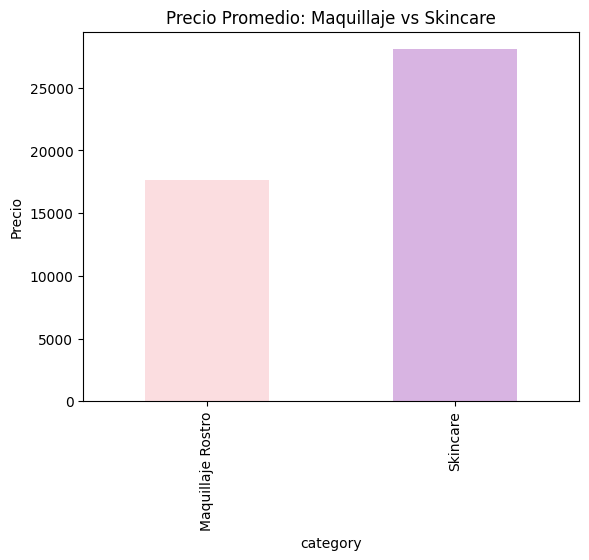

In [14]:
# Precio promedio
colores = ["#FBDDE0", "#D8B4E2"] 
df_total.groupby("category")["price"].mean().plot(kind="bar", color=colores)
plt.title("Precio Promedio: Maquillaje vs Skincare")
plt.ylabel("Precio")
plt.show()

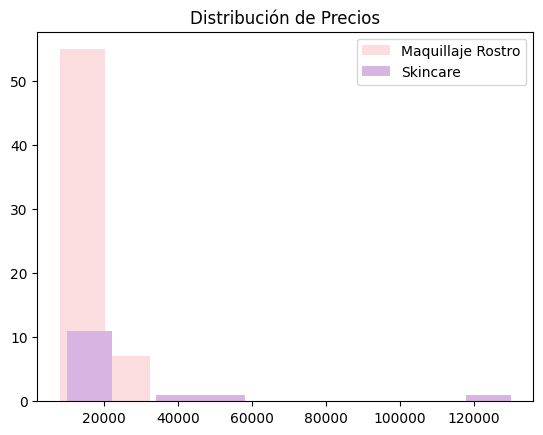

In [18]:
# Distribución de precios
for i, cat in  enumerate(df_total["category"].unique()):
    subset = df_total[df_total["category"] == cat]
    plt.hist(subset["price"], label=cat,color=colores[i])

plt.legend()
plt.title("Distribución de Precios")
plt.show()

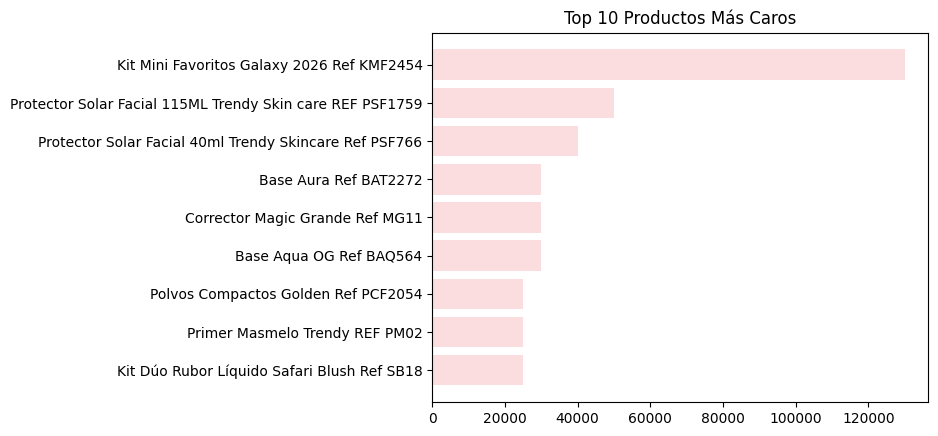

In [35]:
top = df_total.sort_values("price", ascending=False).head(10)

plt.barh(top["name"], top["price"], color = "#FBDDE0")
plt.title("Top 10 Productos Más Caros")
plt.gca().invert_yaxis()
plt.show()

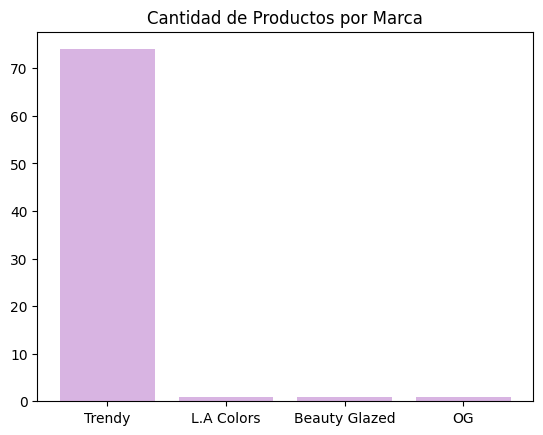

In [36]:
brand_counts = df_total["brand"].value_counts()

plt.bar(brand_counts.index, brand_counts.values, color = "#D8B4E2")
plt.title("Cantidad de Productos por Marca")
plt.show()

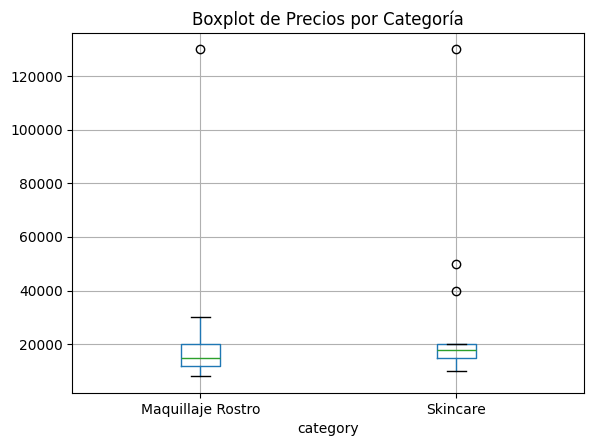

In [19]:
# Boxplot comparativo
df_total.boxplot(column="price", by="category")
plt.title("Boxplot de Precios por Categoría")
plt.suptitle("")
plt.show()

In [25]:
conn = sqlite3.connect("trendy.db")
df_total.to_sql("productos", conn, if_exists="replace", index=False)
conn.commit()
conn.close()

print("\nBase de datos guardada como trendy_comparacion.db")


Base de datos guardada como trendy_comparacion.db


In [21]:
conn = sqlite3.connect("trendy_comparacion.db")

# Leer toda la tabla como DataFrame
df = pd.read_sql_query("SELECT * FROM productos", conn)
print(df)  # Muestra las primeras 5 filas

conn.close()

                                                 name   brand   price  \
0                    Kit Piel Mistic Face Ref KMF2247  Trendy   20000   
1          Kit Mini Favoritos Galaxy 2026 Ref KMF2454  Trendy  130000   
2                          Pin Stitch Guitarra DY2346  Trendy   12000   
3            Kit Rubor y Gloss Pinky News Ref KPN2248  Trendy   15000   
4           Corrector Hidrante Rebel Girl Ref CRG1420  Trendy   10000   
..                                                ...     ...     ...   
72  Protector Solar Facial 115ML Trendy Skin care ...  Trendy   50000   
73        Doypack Serum Hidratante Morado Ref DSH1761  Trendy   10000   
74     Sachet Protector Solar Facial 40ml Ref PSF1213  Trendy   20000   
75         Colapsible Jabón Détox Pequeño Ref JDP1321  Trendy   12000   
76              Doypack Jabón Détox 150ml Ref SJD1507  Trendy   15000   

    list_price           category  discount_%  
0        20000  Maquillaje Rostro         0.0  
1       130000  Maquillaje 